<h1 align=center><font size = 5>Location Selection of City Catering Shops(Week 2/2)</font></h1>

<h1 align=left><font size = 5>Part I:     Screens out the catering types that can open restaurant</font></h1>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import warnings
warnings.filterwarnings('ignore') 

!conda install -c conda-forge geopy --yes   # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
from scipy import stats
import requests                                       # library to handle requests
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.io import output_notebook      # Daw scatter plot 
output_notebook()

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  20.45 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  30.62 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  54.03 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  25.60 MB/s
vincent-0.4.4- 100% |###################

### Data Requirements

1.  Foursquare location data to describe restaurant venues include restaurant's "Price tier", "Rating", "Rating Signals", "Tip Count". 
   
   1)  Search restaurants nearby Neighborhood via Foursqure API Regular Calls
   
   2) query restaurant detail information via Foursqure API Premium Calls. (Premium Calls for Personal Account is 500 Premium Calls / Day. I use Personal Account, so the restaurant detail data I used have limit under 500)
   
   
2. Geographical location to open a shop, we need to consider the consumption population, traffic conditions, popular food, competition, so we can use the following four indicators:Population density index, road density index, popular food index and similar competitive index. These indicators need to be obtained via QGIS for geospatial analysis.

### Data Collection

#### 1. Code in below cell is generated by "IBM Watson Studio" to access file I uploaded in this project '上海市各街道社区乡镇列表.csv' is the processed file from row data "http://www.shjcdj.cn/djWeb/zhuanti/dangjianfuwu/detail.html". It contains the Boroughs of Shanghai, and neighborhoods in each Borough with format which could used by 'geolocator'

In [2]:
# The code was removed by Watson Studio for sharing.

,区县,社区乡镇
0,浦东新区,南汇
1,浦东新区,川沙
2,浦东新区,祝桥镇
3,浦东新区,陆家嘴
4,浦东新区,塘桥


In [4]:
neighborhoods=df_data_1[df_data_1['区县']=='浦东新区'].reset_index(drop=True)

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']     # define the dataframe columns

pudong_data = pd.DataFrame(columns=column_names)                      # instantiate the dataframe

neighborhoods.head()                                                                     # pudong_data.columns= ['Borough', 'Neighborhood'] 

,区县,社区乡镇
0,浦东新区,南汇
1,浦东新区,川沙
2,浦东新区,祝桥镇
3,浦东新区,陆家嘴
4,浦东新区,塘桥


In [5]:
for borough, neighborhood_name  in zip( neighborhoods['区县'], neighborhoods['社区乡镇']):  # Assign the "Latitude, Longitude" to each Neighborhood via geolocator
    address= borough + neighborhood_name
    geolocator = Nominatim(user_agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/22.0.1207.1 Safari/537.1")
    location = geolocator.geocode(address)
    neighborhood_lat = location.latitude
    neighborhood_lon = location.longitude
        
    pudong_data = pudong_data.append({'Borough': borough,
                                                         'Neighborhood': neighborhood_name,
                                                         'Latitude': neighborhood_lat,
                                                         'Longitude': neighborhood_lon}, ignore_index=True)
pudong_data.head()             #print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

,Borough,Neighborhood,Latitude,Longitude
0,浦东新区,南汇,31.105232,121.746517
1,浦东新区,川沙,31.188831,121.693829
2,浦东新区,祝桥镇,31.117293,121.752618
3,浦东新区,陆家嘴,31.240168,121.497945
4,浦东新区,塘桥,31.211636,121.514303


In [6]:
address_shanghaipudong = '上海市浦东新区'     #Let's get the geographical coordinates of Pudong, Shanghai.

geolocator = Nominatim(user_agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/22.0.1207.1 Safari/537.1")
location_pud = geolocator.geocode(address_shanghaipudong)
latitude_pud = location_pud.latitude
longitude_pud = location_pud.longitude
print('The geograpical coordinate of Pudong, Shanghai are {}, {}.'.format(latitude_pud, longitude_pud))

The geograpical coordinate of Pudong, Shanghai are 31.10523225, 121.746516734219.


In [7]:
map_pudong = folium.Map(location=[latitude_pud, longitude_pud], zoom_start=11)    # Visualizat Shanghai Pudong with the neighborhoods in it

for lat, lng, label in zip(pudong_data['Latitude'], pudong_data['Longitude'], pudong_data['Neighborhood']):   # add markers to map
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                                [lat, lng],
                                radius=5,
                                popup=label,
                                color='blue',
                                fill=True,
                                fill_color='#3186cc',
                                fill_opacity=0.7,
                                parse_html=False).add_to(map_pudong)  
map_pudong

In [12]:
CLIENT_ID = 'LL0B20MMD0VX2TKI4Y1QSRSTQXD1GT04WUGT4TYNYY5ISFOF'            # my Foursquare ID         # Define Foursquare Credentials and Version
CLIENT_SECRET = 'RSKPYLR23CCGZC2AQ1LX2HZALJWKFPROFVM42ZIFDB3SOMZU' # my Foursquare Secret
VERSION = '20180605'                                                                                            # Foursquare API version

print(' Your credentails: \n CLIENT_ID:  {} \n CLIENT_SECRET: {}.'.format(CLIENT_ID,CLIENT_SECRET))

 Your credentails: 
 CLIENT_ID:  LL0B20MMD0VX2TKI4Y1QSRSTQXD1GT04WUGT4TYNYY5ISFOF 
 CLIENT_SECRET: RSKPYLR23CCGZC2AQ1LX2HZALJWKFPROFVM42ZIFDB3SOMZU.


#### 2.  Get the restorant's detail information

In [15]:
LIMIT = 2               # limit of number of venues returned by Foursquare API
radius = 20000       # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(
       CLIENT_ID, 
       CLIENT_SECRET, 
       VERSION, 
       neighborhood_latitude, 
       neighborhood_longitude, 
       radius, 
       LIMIT)

In [16]:
results = requests.get(url).json()           #Send the GET request and examine the resutls

In [17]:
def get_category_type(row):     # function that extracts the category of the venue  #Borrow the **get_category_type** function from the Foursquare lab
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']      #Clean the json and structure it into a pandas dataframe.
    
nearby_venues = json_normalize(venues)                # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']   # filter column names
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)         # filter the category for each row

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]                   # clean columns

nearby_venues_bk=nearby_venues

nearby_venues_bk.head()

,name,categories,lat,lng,id
0,Goodfellas,Italian Restaurant,31.234878,121.486730,51bf3806498e121abf501559
1,Din Tai Fung (鼎泰丰),Dumpling Restaurant,31.237007,121.503066,4b8df278f964a520281433e3


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))            #how many venues were returned by Foursquare?

2 venues were returned by Foursquare.


In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500,LIMIT=1):  #create a function to repeat the same process to all the neighborhoods in Pudong
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(   # create the API request URL
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
       
        results = requests.get(url).json()["response"]['groups'][0]['items']     # make the GET request
        
        venues_list.append([(                                                                 # return only relevant information for each nearby venue
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['id'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue ID',
                  'Venue Category']
    
    return(nearby_venues)

In [113]:
pudong_venues = getNearbyVenues(names=pudong_data['Neighborhood'],
                                                   latitudes=pudong_data['Latitude'],
                                                   longitudes=pudong_data['Longitude'])
print(pudong_venues.shape)                 #check the size of the resulting dataframe
pudong_venues.head()

(27, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,川沙,31.188831,121.693829,McDonald's (麦当劳),31.186017,121.695444,501d1b4ee4b09fbdec1dcd2d,Fast Food Restaurant
1,祝桥镇,31.117293,121.752618,老尝客酒店,31.112800,121.762257,5157c111e4b0226ab5362206,Chinese Restaurant
2,陆家嘴,31.240168,121.497945,Morton's The Steakhouse (莫尔顿海鲜牛排坊),31.239197,121.497194,4cdbbda56ad1a0931baeed56,Steakhouse
3,塘桥,31.211636,121.514303,西贝西北菜,31.210547,121.522213,4d2064a76e8c37042202f99f,Chinese Restaurant
4,洋泾,31.241739,121.543177,Caffè Macs,31.236305,121.529036,53ce3fe3498e1f55184da530,Café


In [115]:
def getVenuesDtl(venues_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(venues_id,CLIENT_ID, CLIENT_SECRET, VERSION)
    
    results = requests.get(url).json()
    results_meta=results['meta']['code']
    if results_meta!=200:
        print(results['meta']['errorDetail'])
    
    venues_attr = results['response']['venue']
    venues_dtl = json_normalize(venues_attr) # flatten JSON

    filtered_columns = ['price.tier', 'rating','ratingSignals','stats.tipCount']    #filtered_columns = ['price.tier', 'rating', 'ratingSignals','stats.tipCount']
    venues_dtl =venues_dtl.loc[:, filtered_columns]
    venues_dtl.columns = [col.split(".")[-1] for col in venues_dtl.columns]
    
    return venues_dtl

In [116]:
dtlcolumn_names = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue ID',
                             'Venue Category',
                             'Price Tier',
                             'Rating',
                             'Rating Signals',
                             'Tip Count']

Venue_dtl_data = pd.DataFrame(columns=dtlcolumn_names)      # instantiate the dataframe Venue_dtl_data to store Detailed Venue information

In [117]:
for neighborhood,latitude,longitude,venue,vLatitude,vLongitude,venueID,venueCategory in zip(pudong_venues['Neighborhood'],pudong_venues['Neighborhood Latitude'],pudong_venues['Neighborhood Longitude'],pudong_venues['Venue'],pudong_venues['Venue Latitude'],pudong_venues['Venue Longitude'],pudong_venues['Venue ID'],pudong_venues['Venue Category']):
    
    dtl=getVenuesDtl(venueID)
    dtltier=dtl.tier[0]
    dtlrating=dtl.rating[0]
    dtlratingSignals=dtl.ratingSignals[0]
    dtltipCount=dtl.tipCount[0]
#    print('dtltier: {}  dtlrating:{}  dtlratingSignals:{}  dtltipCount:{}'.format(dtltier,dtlrating, dtlratingSignals, dtltipCount))   
    
    Venue_dtl_data = Venue_dtl_data.append({'Neighborhood':neighborhood,
                                                                'Neighborhood Latitude':latitude,
                                                                'Neighborhood Longitude':longitude,
                                                                'Venue':venue,
                                                                'Venue Latitude':vLatitude,
                                                                'Venue Longitude':vLongitude,
                                                                'Venue ID':venueID,
                                                                'Venue Category':venueCategory,
                                                                'Price Tier':dtltier,
                                                                'Rating':dtlrating,
                                                                'Rating Signals':dtlratingSignals,
                                                                'Tip Count':dtltipCount,
                                                                }, ignore_index=True)

### Data Preparation:Data Screening and Cleaning

In [123]:
Venue_dtl_data.dropna(subset=['Rating'],axis=0,inplace=True)   # Data Screening and Cleaning: Drop rows with 'NaN' value in column "Rating"

Venue_dtl_data['Cost Performance']=Venue_dtl_data['Rating']/Venue_dtl_data['Price Tier']    # Culculate the cost performance

Venue_dtl_data.sort_values(by=["Cost Performance"], ascending=False, inplace=True)        # Sort "Rating Signals","Rating" by descending order 

Venue_dtl_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Price Tier,Rating,Rating Signals,Tip Count,Cost Performance
3,塘桥,31.211636,121.514303,西贝西北菜,31.210547,121.522213,4d2064a76e8c37042202f99f,Chinese Restaurant,1,7.7,22,6,7.7
4,洋泾,31.241739,121.543177,Caffè Macs,31.236305,121.529036,53ce3fe3498e1f55184da530,Café,1,7.6,14,1,7.6
7,周家渡,31.187146,121.489237,历城路小吃一条街,31.176074,121.488183,4f43aee5e4b06bcb6cf3f573,Snack Place,1,7.2,11,1,7.2
11,张江镇,31.207347,121.610182,深山老屋土菜,31.213407,121.608222,4e9e539ddab4b02e64f1a089,Chinese Restaurant,1,7.1,9,2,7.1
0,川沙,31.188831,121.693829,McDonald's (麦当劳),31.186017,121.695444,501d1b4ee4b09fbdec1dcd2d,Fast Food Restaurant,1,6.6,5,0,6.6
16,高行镇,31.294780,121.602323,Starbucks (星巴克),31.298115,121.587683,593f4676db1d8124e8760148,Café,1,6.5,0,0,6.5
20,周浦镇,31.116213,121.570770,McDonald's (麦当劳),31.116981,121.564458,4daa4b6c6a2303012f0b8481,Fast Food Restaurant,1,6.4,3,0,6.4
23,惠南镇,31.049750,121.745087,McDonald's (麦当劳),31.054962,121.759193,58bdfbdef8408575c4c76f27,Fast Food Restaurant,1,6.4,1,0,6.4
12,唐镇,31.210360,121.651043,McDonald's (麦当劳),31.214108,121.655692,5a4e148c9fca563f2af9b70b,Fast Food Restaurant,1,6.3,1,0,6.3
17,三林镇,31.147273,121.497953,KFC,31.151598,121.487892,50e6b54ee4b0cbb777e3c427,Fast Food Restaurant,1,6.2,2,1,6.2


## Data Visualization

Visualizing Data using Matplotlib

In [124]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

print('Matplotlib version: ', mpl.__version__) # >= 2.0.0   # check for latest version of Matplotlib

Matplotlib version:  2.1.0


In [140]:
dvcolumn_names = ['Venue Category','Cost Performance']
DV_data = pd.DataFrame(columns=dvcolumn_names) 
DV_data['Venue Category'] = Venue_dtl_data['Venue Category']
DV_data['Cost Performance']=Venue_dtl_data['Cost Performance']
DV_data.head()

,Venue Category,Cost Performance
3,Chinese Restaurant,7.7
4,Café,7.6
7,Snack Place,7.2
11,Chinese Restaurant,7.1
0,Fast Food Restaurant,6.6


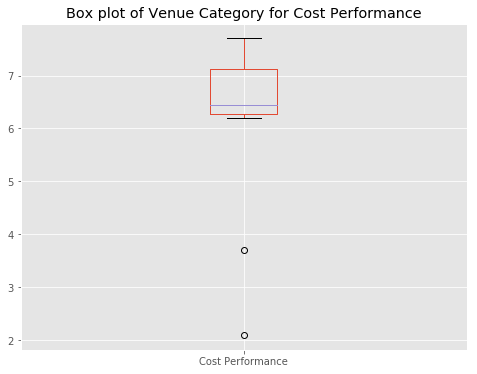

In [143]:
DV_data.plot(kind='box', figsize=(8, 6))

plt.title('Box plot of Venue Category for Cost Performance')

plt.show()

### As per analysis according to Cost Perfomance, I recommond to "Chinese Restaurant" as catering shop type.




<h1 align=left><font size = 5>Part II:        Restaurant location recommandation</font></h1>

The following four indicators can be used:
1. Population density index 
2. Road density index 
3. Restorants nunber index

These indicators need to be obtained by using QGIS for geospatial analysis.


Evaluation methods:

Population Density Index The Higher the Score, the Better

Road Density Index The Higher the Score, the Better

Restorants Index The Higher the Score, the Better

Comprehensive Index = Population Density Index * 0.4 + Catering Heat Index * 0.3 + Road Density Index * 0.2

After labeling the four indicators, the weighted average is used to get the comprehensive indicators, and the top10 area is selected as the candidate area by comprehensive ranking.


In [151]:

body = client_7c91af86e769468280b8a6779c566e74.get_object(Bucket='myproject-donotdelete-pr-yifrepzij7a07s',Key='ShanghaiQGIS_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()

,Population Pensity,Road Length,Restorants,Longitude,Latitude
0,0,0.000000,0.0,121.273114,30.685411
1,0,128.477758,NaN,121.262516,30.694291
2,0,1539.908057,NaN,121.272953,30.694430
3,0,1032.299541,NaN,121.283390,30.694569
4,0,1543.891782,NaN,121.293827,30.694706


### Data Standardization

In [165]:
df_data=df_data_2.replace(np.nan,0)       # Process "NaN" values. replace it with 0
df_data.head()

,Population Pensity,Road Length,Restorants,Longitude,Latitude
0,0,0.000000,0.0,121.273114,30.685411
1,0,128.477758,0.0,121.262516,30.694291
2,0,1539.908057,0.0,121.272953,30.694430
3,0,1032.299541,0.0,121.283390,30.694569
4,0,1543.891782,0.0,121.293827,30.694706


In [166]:
#Population Density Index The Higher the Score, the Better
df_data['Population Nor'] = (df_data['Population Pensity']-df_data['Population Pensity'].min())/(df_data['Population Pensity'].max()-df_data['Population Pensity'].min())

#Road Density Index The Higher the Score, the Better
df_data['RoadLenght Nor'] = (df_data['Road Length']-df_data['Road Length'].min())/(df_data['Road Length'].max()-df_data['Road Length'].min())

#Restorants Index The Higher the Score, the Better
df_data['Restorants Nor'] = (df_data['Restorants']-df_data['Restorants'].min())/(df_data['Restorants'].max()-df_data['Restorants'].min())

In [167]:
#Comprehensive Index
df_data['Score'] = df_data['Population Nor']*0.4+df_data['RoadLenght Nor']*0.2+df_data['Restorants Nor']*0.3

In [169]:
df_score = df_data[['Longitude','Latitude','Score']].sort_values('Score',ascending =False) 

In [171]:
df_score['Size'] = df_score['Score']*20  #Plot size 
df_score['Color'] = 'green'                    #color
df_score['Color'].iloc[:10] = 'red'           #top10 locations in red

In [174]:
source = ColumnDataSource(data = df_score)

In [189]:
hover = HoverTool(tooltips = [('Longitude','@Longitude'),
                                          ('Latitude','@Latitude'),
                                          ('Score','@Score')
                                          ])

p= figure(plot_width = 800,plot_height = 800,title = ' Restaurant location recommandation in Red color',tools = [hover,'box_select,wheel_zoom,reset,crosshair'])

In [190]:
p.square(x= 'Longitude',y='Latitude',source = source,size = 'Size',line_color = 'black',fill_color ='Color',fill_alpha = 0.5)
p.xgrid.grid_line_dash = [10,4]
p.ygrid.grid_line_dash = [10,4]

show(p)